<a href="https://colab.research.google.com/github/ekourkchi/incNET/blob/master/CNN_inc_CGG6_regr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random

# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
data = np.load('/content/drive/My Drive/data_56x56.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

51


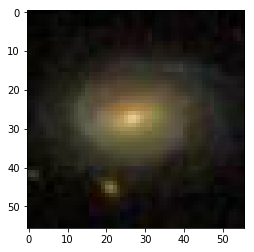

In [3]:
i = 53
print labels_[1][i]
plt.imshow(images_[i])

(array([3220., 2460., 2532., 3296., 3188., 4936., 4940., 5692., 5208.,
        7552.]),
 array([51. , 54.9, 58.8, 62.7, 66.6, 70.5, 74.4, 78.3, 82.2, 86.1, 90. ]),
 <a list of 10 Patch objects>)

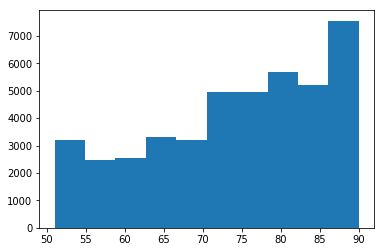

In [4]:
plt.hist(labels_[1][labels_[1]>50])

(60468, 56, 56, 3)
(43024, 56, 56, 3)
52


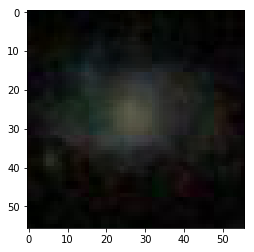

In [5]:
print images_.shape
ix, = np.where(labels_[1]>50)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

print images_c.shape

i = 100
plt.imshow(images_c[i])
print labels_c[i]


In [0]:
def esn_shuffle(array, seed=0):
        random.seed(seed)
        random.shuffle(array)
        return array

In [0]:
n = len(labels_c)

indices = np.arange(n)
indices = esn_shuffle(indices, seed=0)


images_cc = images_c[indices]
labels_cc = labels_c[indices]
pgcIDs_cc = pgcIDs_c[indices]

#################

indices = np.arange(1000)
images_test  = images_cc[indices]
lables_test  = labels_cc[indices]
pgcIDs_test  = pgcIDs_cc[indices]

################# 

indices = np.arange(1000, n)
images_train = images_cc[indices]
lables_train = labels_cc[indices]
pgcIDs_train = pgcIDs_cc[indices]


ibx = np.logical_not(np.isin(pgcIDs_train, pgcIDs_test))
images_train = images_train[ibx]
lables_train = lables_train[ibx]
pgcIDs_train = pgcIDs_train[ibx]

#################
# Taking only unique galxies in the test set
# This is the brute-force approach.
# I need to make this better in the future

unique_IDs = []
unique_inx = []

for i, id in enumerate(pgcIDs_test):
    if not id in unique_IDs:
        unique_IDs.append(id)
        unique_inx.append(i)
        
        
images_test  = images_test[unique_inx]
lables_test  = lables_test[unique_inx]
pgcIDs_test  = pgcIDs_test[unique_inx]

In [8]:
print images_train.shape , lables_train.shape
print images_test.shape , lables_test.shape


(39180, 56, 56, 3) (39180,)
(961, 56, 56, 3) (961,)


(array([ 71.,  54.,  55.,  56.,  85.,  98.,  94., 142., 133., 173.]),
 array([51. , 54.9, 58.8, 62.7, 66.6, 70.5, 74.4, 78.3, 82.2, 86.1, 90. ]),
 <a list of 1 Patch objects>)

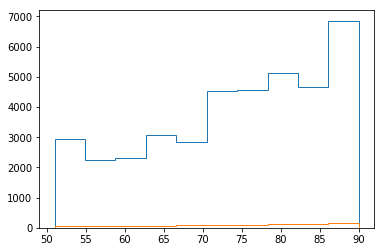

In [9]:
plt.hist(lables_train, histtype='step', label='train')
plt.hist(lables_test, histtype='step', label='test')

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(56, 56, 3), n_classes= 8):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.10))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.10))
    
    model.add(tf.keras.layers.Dense(128, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.10))
    
    model.add(tf.keras.layers.Dense(56, activation='relu', name='fc_3'))
    model.add(tf.keras.layers.Dropout(0.10))
    
    # output layer
    model.add(tf.keras.layers.Dense(1, name='fc_out'))

    return model

In [11]:
vgg_model = vgg6()
vgg_model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
n_epochs=100
vgg_model.summary()
vgg_model_history = vgg_model.fit(images_train, lables_train, 
                                  epochs=n_epochs, batch_size=512, 
                                  validation_data=(images_test, lables_test),
                                  verbose=2, shuffle=True)


W0208 05:45:11.972744 140024663521152 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling __init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 54, 54, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 52, 52, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 22, 22, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 22, 22, 32)        128    

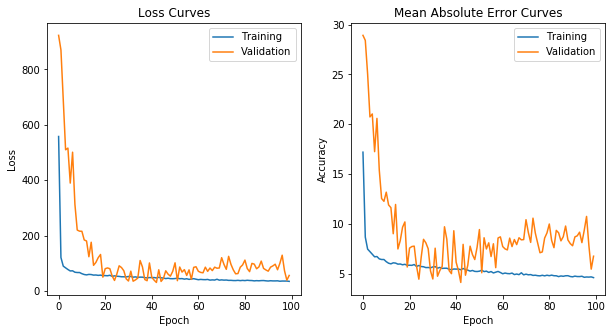

In [12]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
# plot the training history
# for key in vgg_model.history.history:
#   print key

plot_model_history(vgg_model.history)
  

In [13]:
vgg_model.save("/content/drive/My Drive/CNN_inc_VGG6_regr.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
inc_p = vgg_model.predict(images_test)
inc_m = lables_test


N = images_test.shape[0]
inc_p = inc_p.reshape(N)

In [15]:
images_test.shape

(961, 56, 56, 3)

65.13967
73


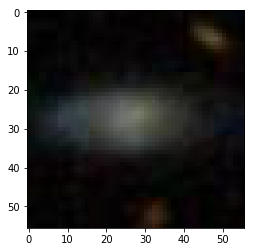

In [16]:
i = 801
print inc_p[i]
print inc_m[i]
plt.imshow(images_test[i])

7.462244639007458
3.7882843636591117


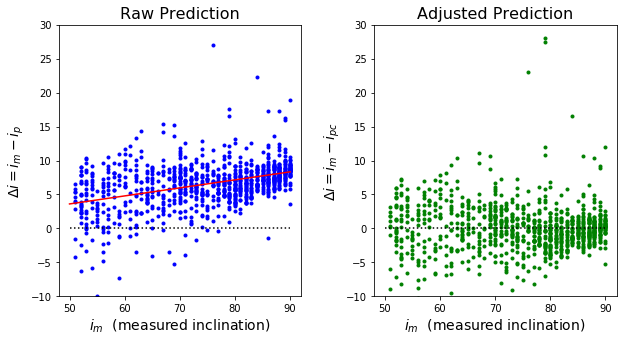

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-10,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print np.sqrt(np.mean((d)**2))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-10,30)

print np.sqrt(np.mean((d_)**2))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

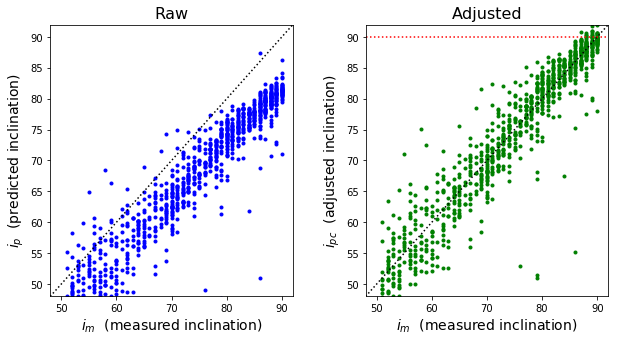

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, 'b.')
ax[0].plot([48,92],[48,92], 'k:')
ax[0].set_xlim(48,92)
ax[0].set_ylim(48,92)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([48,92],[48,92], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(48,92)
ax[1].plot([48,92],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)